In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

result_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/ModelAnalysis/'
figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/Figures/'
save = False

draws = [99,199,299,399,499]
# load in the results
conds = ['neutral', 'P-0_I-0.15_O-0 - valid', 'P-0_I-0.15_O-0 - invalid',
         'P-0_I-0_O-0.3 - valid', 'P-0_I-0_O-0.3 - invalid',
         'P-1_I-0_O-0 - valid', 'P-1_I-0_O-0 - invalid']

for cond in conds:
    for draw in draws:
        if draw == 99:
            results_cond = pd.read_pickle(result_path + 'RDMFits/Fits_corr_' + str(draw) + '_' + cond + '.pkl')
        else:
            results_cond = results_cond.append(pd.read_pickle(result_path + 'RDMFits/Fits_corr_' + str(draw) + '_' + cond + '.pkl'))

    if cond == 'neutral':
        results = results_cond
    else:
        results = results.append(results_cond, ignore_index=True)

onset = 100
start_eval = 250 - onset
results['Time'] = results['Time']-onset
results['Partial Correlation - Analog'] = results['Partial Correlation - Analog'].apply(pd.to_numeric)
results['Partial Correlation - Category'] = results['Partial Correlation - Category'].apply(pd.to_numeric)
results['Correlation - Analog'] = results['Correlation - Analog'].apply(pd.to_numeric)
results['Correlation - Category'] = results['Correlation - Category'].apply(pd.to_numeric)


variables = ['Correlation - Analog', 'Correlation - Category','Partial Correlation - Analog', 'Partial Correlation - Category']
# make an attention condition
results['Attention'] =results['Model'].str.split(' - ', expand=True)[1]

results['Diff- Partial Correlation - Analog'] = results['Partial Correlation - Analog'] - \
                                                results.loc[(results['Time'] >=start_eval) & (results['Model']=='neutral'),'Partial Correlation - Analog'].mean()
results['Diff- Partial Correlation - Category'] = results['Partial Correlation - Category'] - \
                                                results.loc[(results['Time'] >=start_eval) & (results['Model']=='neutral'),'Partial Correlation - Category'].mean()

results.loc[:,'Condition'] = results.loc[:,'Model']
results.loc[:,'Attention'] = results.loc[:,'Model'].str.split(' - ', expand=True)[1]
results.loc[:,'Model'] = results.loc[:,'Model'].str.split(' - ', expand=True)[0]


colors = sns.color_palette(sns.xkcd_palette(["greyish", "wine", "moss", "ocean blue", "faded green", "dusty purple"]))
colors_cues = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

lower_bound = results.groupby(['Time', 'Condition'])[variables].quantile(0.025).reset_index()
upper_bound = results.groupby(['Time', 'Condition'])[variables].quantile(0.975).reset_index()


times = np.arange(results['Time'].min(), results['Time'].max()+1)

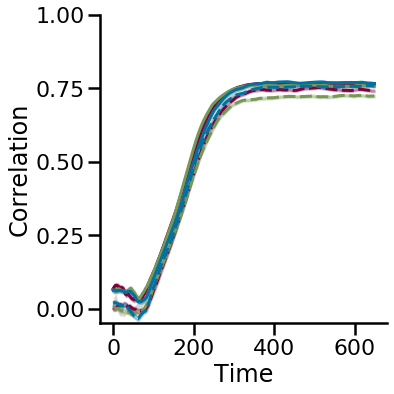

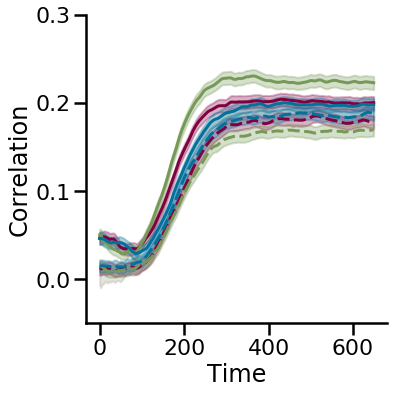

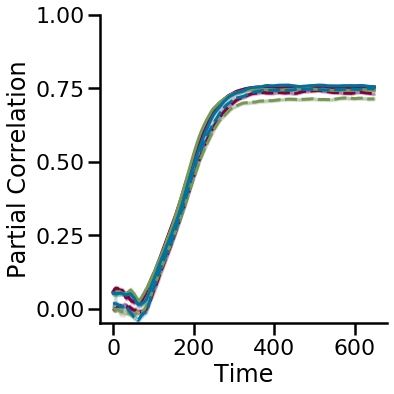

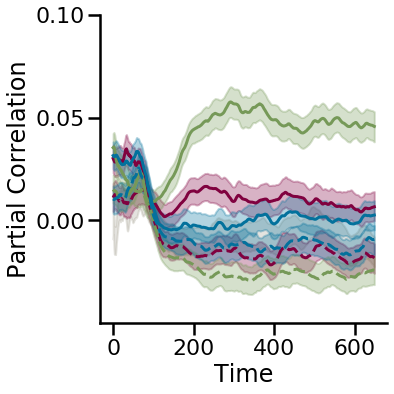

In [4]:
sns.set_context("poster")
for v, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(6, 6))
    if var == 'Correlation - Analog':
        legend_arg = None
    else:
        legend_arg = None

    sns.lineplot(x='Time', y=var, hue='Condition', data=results, ci=None,
                 palette={'neutral': colors[0],
                          'P-0_I-0.15_O-0 - valid': colors[1], 'P-0_I-0.15_O-0 - invalid': colors[1],
                          'P-0_I-0_O-0.3 - valid': colors[2], 'P-0_I-0_O-0.3 - invalid': colors[2],
                          'P-1_I-0_O-0 - valid': colors[3], 'P-1_I-0_O-0 - invalid': colors[3]},
                 style='Attention', legend=legend_arg, ax=ax)

    ax.set_ylabel(var.split(' - ')[0])

    if var == 'Partial Correlation - Category':
        ax.set_ylim([-0.05, 0.1])
        ax.set_yticks([0, 0.05, 0.1 ])
    elif var == 'Partial Correlation - Analog':
        ax.set_ylim([-0.05, 1])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1 ])
    elif var == 'Correlation - Analog':
        ax.set_ylim([-0.05, 1])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1 ])

    elif var == 'Correlation - Category':
        ax.set_ylim([-0.05, 0.3])
        ax.set_yticks([0, 0.1, 0.2, 0.3])

    for cond in conds:
        if cond.startswith('neutral'):
            col_curr = colors[0]
        elif cond.startswith('P-0_I-0.15_O-0'):
            col_curr = colors[1]
        elif cond.startswith('P-0_I-0_O-0.3'):
            col_curr = colors[2]
        elif cond.startswith('P-1_I-0_O-0'):
            col_curr = colors[3]

        ax.fill_between(times, lower_bound.loc[lower_bound['Condition']==cond, var],
                         upper_bound.loc[upper_bound['Condition']==cond, var], alpha=0.3, color=col_curr)

    sns.despine(ax=ax)
    plt.tight_layout()
    if save == True:
        fig.savefig(figure_path + 'RDM-Fits_' + var + '.pdf', dpi=300, transparent=True)
    else:
        fig.show()


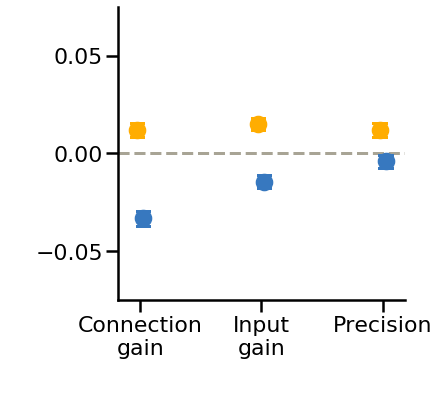

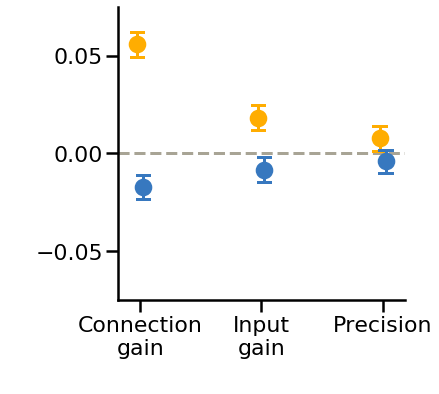

In [6]:
dodge=True
capsize = 0.1
aspect = 1.1
errwidth = 3
conds_all = ['P-0_I-0_O-0.3', 'P-0_I-0.15_O-0', 'P-1_I-0_O-0']
for var in ['Diff- Partial Correlation - Analog', 'Diff- Partial Correlation - Category']:

    g = sns.catplot(x='Model', y=var, hue='Attention',  palette={'None': colors_cues[2],
                          'valid': colors_cues[0],'invalid': colors_cues[1]},
                 data=results[(results['Time'] >= start_eval) & (results['Model']!='neutral')],
                  kind='point',ci=None, height=6, aspect=aspect, join=False, dodge=dodge, legend=None,
                    order=conds_all)
    g.ax.set_xticklabels(['Connection\ngain', 'Input\ngain', 'Precision'])
    g.ax.axhline(0, color=colors_cues[2], ls='--', zorder=0)
    g.ax.set_xlabel(' ')
    g.ax.set_ylabel(' ')
    g.ax.set_ylim([-0.075, 0.075])
    g.ax.set_yticks([-0.05, 0, 0.05])

    low_CI = results[(results['Time'] >= start_eval) & (results['Model']!='neutral')].groupby(['Model', 'Attention', 'Draw'])[var].mean().reset_index().groupby(['Model', 'Attention']).quantile(0.025).reset_index()
    high_CI =results[(results['Time'] >= start_eval) & (results['Model']!='neutral')].groupby(['Model', 'Attention','Draw'])[var].mean().reset_index().groupby(['Model', 'Attention']).quantile(0.975).reset_index()

    if dodge:
        offset = np.linspace(0, 0.045 * aspect, 2)  # 0.025
        offset -= offset.mean()
    i = 0
    for a, att in enumerate(['valid', 'invalid']):
        for c, cond in enumerate(conds_all):
            at = np.arange(len(conds_all))[c] + offset[a]
            ci_low = low_CI.loc[(low_CI['Model'] == cond) &(low_CI['Attention'] == att), var].values
            ci_high = high_CI.loc[(high_CI['Model'] == cond) & (high_CI['Attention'] == att), var].values
            g.ax.plot([at, at], [ci_low, ci_high], color=colors_cues[a], zorder=1, lw=errwidth)
            if capsize is not None:
                g.ax.plot([at - capsize / 2, at + capsize / 2],[ci_low, ci_low],  color=colors_cues[a], zorder=1,
                          lw=errwidth)
                g.ax.plot([at - capsize / 2, at + capsize / 2],[ci_high, ci_high], color=colors_cues[a], zorder=1,
                          lw=errwidth)

    plt.tight_layout()
    if save == True:
        plt.savefig(figure_path + 'RDM-Fits_' + var + '.pdf', dpi=300, transparent=True)
    else:
        plt.show()


In [ ]:
#  statistics
dvs = ['Diff- Partial Correlation - Analog',
       'Diff- Partial Correlation - Category']

comps = ['P-0_I-0.15_O-0 - valid vs. 0',
         'P-0_I-0_O-0.3 - valid vs. 0',
         'P-1_I-0_O-0 - valid vs. 0',
         'P-0_I-0.15_O-0 - valid vs. P-0_I-0_O-0.3 - valid',
         'P-0_I-0.15_O-0 - valid vs. P-1_I-0_O-0 - valid',
         'P-0_I-0_O-0.3 - valid vs. P-1_I-0_O-0 - valid',
         'P-0_I-0.15_O-0 - invalid vs. P-0_I-0_O-0.3 - invalid',
         'P-0_I-0.15_O-0 - invalid vs. P-1_I-0_O-0 - invalid',
         'P-0_I-0_O-0.3 - invalid vs. P-1_I-0_O-0 - invalid',
         'P-0_I-0.15_O-0 - invalid vs. 0',
         'P-0_I-0_O-0.3 - invalid vs. 0',
         'P-1_I-0_O-0 - invalid vs. 0'
         ]


plot = False
stats = {}
null_value = 0
ps = []
for dv in dvs:
    if dv not in stats:
        stats[dv] = {}
    for comp in comps:
        if comp not in stats[dv]:
            stats[dv][comp] = {}
        cands = comp.split(' vs. ')
        if cands[1] == '0':
            diff = results.loc[(results['Condition'] == cands[0]) & (results['Time'] >= start_eval)].groupby(['Draw'])[dv].mean()

        else:
            var1 = results.loc[(results['Condition'] == cands[0])  & (results['Time'] >=start_eval)]
            var2 = results.loc[(results['Condition'] == cands[1]) & (results['Time'] >=start_eval)]
            #var3 = results.loc[(results['Condition'] == 'P-1_I-0_O-0.3 - valid') & (results['Time'] >= start_eval)]


            diff = var2.groupby(['Draw'])[dv].mean() - var1.groupby(['Draw'])[dv].mean()
        if plot == True:
            plt.figure(figsize=(10,10))
            sns.distplot(diff)
            plt.title(dv + '\n' + comp)
            plt.axvline(0, color='r')
            plt.show()

        half_p_val = np.mean(diff > null_value) + 0.5 * np.mean(diff == null_value)

        p_val = 2 * np.min([half_p_val, 1-half_p_val])

        stats[dv][comp]['p'] = p_val
        stats[dv][comp]['CI'] = [np.percentile(diff, 2.5),np.percentile(diff, 97.5)]
        stats[dv][comp]['median'] = np.median(diff)

joblib.dump(stats, result_path + 'RDMFits_Comparisons.pkl',
            compress=True)
